# Aggregate Interaction and association data into a Network
* Known interactions are setup within a global network:
    * Drug-Drug interactions (DDI)
        * DrugBank
        * Continuous Drug Combination Database (CDCDB)
    * Drug-Protein interactions (DPI)
        * DrugBank
    * Drug-SNP interactions
        * DrugBank
    * Protein-SNP associations
        * UniProt
        * dbSNP
    * Protein-Phenotype interactions (a.k.a genotype-phenotype)
        * MIM

For best results, run the following notebooks to ensure extracted data is up to date:
* For UniProt data: [ExtractDataAnnotations_UniProt](./annotation/ExtractDataAnnotations_UniProt.ipynb)
* For DrugBank data: [ExtractDrugData_DrugBank](./data/ExtractDrugData_DrugBank.ipynb)
* For SNP data: [ExtractDrugData_DrugBank](./data/ExtractDrugData_DrugBank.ipynb)
* For MIM data: [ExtractDataAnnotations_MIM](./annotation/ExtractDataAnnotations_MIM.ipynb)

Once the basic interaction structure is created, various node and attributes can be extracted from the relevant sources 
It is expected that this notebook will grow over time and extract additional relevant information for nodes/edges to create a knowledge-graph setup.
## Setup
### Import packages

In [1]:
from collections import defaultdict
import pandas as pd

from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    GEM_NAME,
    read_rbc_model,
    split_string,
    get_annotation_df,
    show_versions,
    build_string,
)
from rbc_gem_utils.visualization import cmap_map
from rbc_gem_utils.database import (
    MIM_PATH,
    MIM_DB_TAG,
    DRUGBANK_PATH,
    DRUGBANK_DB_TAG,
    CDCDB_PATH,
    CDCDB_DB_TAG,
)
from rbc_gem_utils.util import explode_column, strip_plural

show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [2]:
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,1457f5590
Number of metabolites,1971
Number of reactions,2798
Number of genes,656
Number of groups,75
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [3]:
annotation_type = "genes"
df_model_mappings = get_annotation_df(
    getattr(model, annotation_type),
    [
        "uniprot",
        "hgnc.symbol",
        "drugbank",
        "dbsnp",
        "mim",
        "ec-code",
        "orphanet",
        "pubchem.compound",
    ],
).rename({"id": annotation_type}, axis=1)
for col in df_model_mappings.columns:
    df = df_model_mappings[col].apply(split_string).explode(col).drop_duplicates()
    print(f"{df.name}: {df.nunique()}")

df_model_mappings

genes: 656
uniprot: 656
hgnc.symbol: 657
drugbank: 2066
dbsnp: 4308
mim: 1142
ec-code: 487
orphanet: 460
pubchem.compound: 1152


,genes,uniprot,hgnc.symbol,drugbank,dbsnp,mim,ec-code,orphanet,pubchem.compound
0,RPE,Q96AT9,RPE,DB00153,NaN,180480,5.1.3.1,NaN,5280793
1,RPIA,P49247,RPIA,DB01756,rs121918591,180430;608611,5.3.1.6,440706,NaN
2,SORD,Q00796,SORD,DB00157;DB04478,rs145813597;rs1042079;rs930337;rs149975952,182500;618912,1.1.1.-;1.1.1.14;1.1.1.4;1.1.1.56;1.1.1.9,NaN,NaN
3,AKR7A2,O43488,AKR7A2,NaN,rs6670759;rs1043657;rs859208;rs859210;rs223120...,603418,1.1.1.n11,NaN,NaN
4,SRM,P19623,SRM,DB00118,rs1049932,182891,2.5.1.16,NaN,34755
...,...,...,...,...,...,...,...,...,...
651,SLC9B2,Q86UD5,SLC9B2,NaN,rs7672710;rs7672707;rs2276976,611789,NaN,NaN,NaN
652,SMPD1,P17405,SMPD1,DB00381;DB00477;DB01151;DB12151;DB14009,rs550365194;rs1050228;rs3838786;rs748589919;rs...,257200;607608;607616,3.1.4.12;3.1.4.3,77293;77292,2162;2726;2995;483477;60496;6435922;65327
653,SPHK1,Q9NYA1,SPHK1,DB08868,rs346803,603730,2.3.1.-;2.7.1.91,NaN,107969;107970
654,TRPC6,Q9Y210,TRPC6,NaN,rs3802829;rs121434390;rs146776939;rs121434391;...,603652;603965,NaN,656,NaN


### Setup node alias table and data dictionaries

In [4]:
# Edge data
interaction_dfs = defaultdict(list)

protein_node_id_type = "uniprot"
df_network_node_aliases = df_model_mappings[
    [protein_node_id_type, protein_node_id_type]
].copy()
df_network_node_aliases.columns = ["node_id", "node_alias"]
df_network_node_aliases["node_source"] = protein_node_id_type
df_network_node_aliases["node_type"] = "gene/protein"
df_network_node_aliases["alias_type"] = "identifier"
for key, alias_type in zip(["genes", "hgnc.symbol"], ["identifier", "symbol"]):
    df = df_model_mappings.loc[:, [protein_node_id_type, key]]
    if key != "genes":
        df["node_source"] = key
    else:
        df["node_source"] = GEM_NAME
        df[key] = df[key].apply(lambda x: f"G_{x}")
    df["node_type"] = "gene/protein"
    df["alias_type"] = alias_type

    df_network_node_aliases = pd.concat(
        (
            df_network_node_aliases,
            df.rename(
                {
                    protein_node_id_type: "node_id",
                    key: "node_alias",
                },
                axis=1,
            ),
        )
    )
node_types_keys = {
    "drug": "drugbank",
    "snp": "dbsnp",
}
for node_type, key in node_types_keys.items():
    list_of_ids = sorted(
        df_model_mappings[key].apply(split_string).explode(key).dropna().unique()
    )
    df = pd.DataFrame.from_dict(
        {
            "node_id": list_of_ids,
            "node_alias": list_of_ids,
            "node_source": [key] * len(list_of_ids),
            "node_type": [node_type] * len(list_of_ids),
            "alias_type": "identifier",
        },
        orient="columns",
    )
    df_network_node_aliases = pd.concat(
        (
            df_network_node_aliases,
            df,
        )
    )

# Note that node aliases at this point may include nodes that never get connected. Nodes are pruned after edges are created
node_types = (
    df_network_node_aliases.groupby("node_type")["node_alias"]
    .agg(lambda x: set(x.unique()))
    .to_dict()
)
df_network_node_aliases

,node_id,node_alias,node_source,node_type,alias_type
0,Q96AT9,Q96AT9,uniprot,gene/protein,identifier
1,P49247,P49247,uniprot,gene/protein,identifier
2,Q00796,Q00796,uniprot,gene/protein,identifier
3,O43488,O43488,uniprot,gene/protein,identifier
4,P19623,P19623,uniprot,gene/protein,identifier
...,...,...,...,...,...
4303,rs990831395,rs990831395,dbsnp,snp,identifier
4304,rs9948825,rs9948825,dbsnp,snp,identifier
4305,rs9972332,rs9972332,dbsnp,snp,identifier
4306,rs9980589,rs9980589,dbsnp,snp,identifier


## Load interaction data
#### Load drug interactions
##### With other drugs 

In [5]:
df_interactions = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}{DRUGBANK_PATH}/Interactions_{DRUGBANK_DB_TAG}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)
# Add names to aliases
df = pd.concat(
    (
        df_interactions.loc[:, ["drugbank_A", "name_A"]].rename(
            {"drugbank_A": "node_id", "name_A": "node_alias"}, axis=1
        ),
        df_interactions.loc[:, ["drugbank_B", "name_B"]].rename(
            {"drugbank_B": "node_id", "name_B": "node_alias"}, axis=1
        ),
    ),
    axis=0,
).drop_duplicates()
df["node_source"] = "drugbank"  # Is INN?
df["node_type"] = "drug"
df["alias_type"] = "name"

df_network_node_aliases = (
    pd.concat(
        (
            df_network_node_aliases,
            df,
        ),
        axis=0,
    )
    .drop_duplicates()
    .reset_index(drop=True)
)
df_network_node_aliases

# Add Drug Drug mappings
edge_type = "drug-drug"
rename_mapping = {
    "drugbank_A": "node_A",
    "drugbank_B": "node_B",
}

df_interactions = df_interactions.loc[:, list(rename_mapping)].rename(
    rename_mapping, axis=1
)
df_interactions = df_interactions[df_interactions["node_A"].isin(node_types["drug"])]
df_interactions = df_interactions[df_interactions["node_B"].isin(node_types["drug"])]
df_interactions = df_interactions.drop_duplicates().reset_index(drop=True)
df_interactions["edge_type"] = edge_type
df_interactions["edge_subtype"] = float("nan")
df_interactions["edge_source"] = "drugbank"
interaction_dfs[edge_type] += [df_interactions.copy()]
df_interactions

,node_A,node_B,edge_type,edge_subtype,edge_source
0,DB00027,DB01418,drug-drug,NaN,drugbank
1,DB00027,DB08794,drug-drug,NaN,drugbank
2,DB00027,DB00281,drug-drug,NaN,drugbank
3,DB00027,DB00721,drug-drug,NaN,drugbank
4,DB00027,DB00814,drug-drug,NaN,drugbank
...,...,...,...,...,...
214886,DB16650,DB17472,drug-drug,NaN,drugbank
214887,DB16690,DB16703,drug-drug,NaN,drugbank
214888,DB16703,DB17472,drug-drug,NaN,drugbank
214889,DB16703,DB16826,drug-drug,NaN,drugbank


##### With proteins

In [6]:
df_interactions = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}{DRUGBANK_PATH}/Proteins_{DRUGBANK_DB_TAG}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)
edge_type = "drug-gene/protein"
# Add Drug Protein mappings
rename_mapping = {
    "drugbank-id": "node_A",
    "polypeptide.uniprot-id": "node_B",
    "type": "edge_subtype",
}
df_interactions = df_interactions.loc[:, list(rename_mapping)].rename(
    rename_mapping, axis=1
)
df_interactions = df_interactions[df_interactions["node_A"].isin(node_types["drug"])]
df_interactions = df_interactions[
    df_interactions["node_B"].isin(node_types["gene/protein"])
]
df_interactions = df_interactions.drop_duplicates().reset_index(drop=True)
df_interactions["edge_type"] = edge_type
df_interactions["edge_source"] = "drugbank"
interaction_dfs[edge_type] += [df_interactions.copy()]
df_interactions

,node_A,node_B,edge_subtype,edge_type,edge_source
0,DB00027,P08183,transporters,drug-gene/protein,drugbank
1,DB00030,P06213,targets,drug-gene/protein,drugbank
2,DB00035,P35354,enzymes,drug-gene/protein,drugbank
3,DB00041,P35354,enzymes,drug-gene/protein,drugbank
4,DB00041,P47712,enzymes,drug-gene/protein,drugbank
...,...,...,...,...,...
3716,DB16826,P08183,transporters,drug-gene/protein,drugbank
3717,DB17083,Q9UNQ0,transporters,drug-gene/protein,drugbank
3718,DB17472,P08183,transporters,drug-gene/protein,drugbank
3719,DB17472,Q9UNQ0,transporters,drug-gene/protein,drugbank


##### With SNPs

In [7]:
df_interactions = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}{DRUGBANK_PATH}/SNP_{DRUGBANK_DB_TAG}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)
edge_type = "drug-snp"
df_interactions["edge_subtype"] = df_interactions["adverse-reaction"].notna()

# Add Drug SNP mappings
rename_mapping = {
    "drugbank-id": "node_A",
    "rs-id": "node_B",
    "edge_subtype": "edge_subtype",
}
df_interactions = df_interactions.loc[:, list(rename_mapping)].rename(
    rename_mapping, axis=1
)
df_interactions = df_interactions[df_interactions["node_A"].isin(node_types["drug"])]
df_interactions = df_interactions[df_interactions["node_B"].isin(node_types["snp"])]
df_interactions = df_interactions.drop_duplicates().reset_index(drop=True)
df_interactions["edge_type"] = edge_type
df_interactions["edge_source"] = "drugbank"
df_interactions["edge_subtype"] = df_interactions["edge_subtype"].apply(
    lambda x: "known-effect-adverse" if x else "known-effect"
)
interaction_dfs[edge_type] += [df_interactions.copy()]
df_interactions

,node_A,node_B,edge_subtype,edge_type,edge_source
0,DB00317,rs2231142,known-effect-adverse,drug-snp,drugbank
1,DB00352,rs1800462,known-effect-adverse,drug-snp,drugbank
2,DB00352,rs1800460,known-effect-adverse,drug-snp,drugbank
3,DB00352,rs1142345,known-effect-adverse,drug-snp,drugbank
4,DB00544,rs1695,known-effect-adverse,drug-snp,drugbank
5,DB00864,rs2032582,known-effect-adverse,drug-snp,drugbank
6,DB00993,rs1800462,known-effect-adverse,drug-snp,drugbank
7,DB00993,rs1800460,known-effect-adverse,drug-snp,drugbank
8,DB00993,rs1142345,known-effect-adverse,drug-snp,drugbank
9,DB01033,rs1800462,known-effect-adverse,drug-snp,drugbank


#### Load protein SNPs

In [8]:
df_interactions = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}/snps_{GEM_NAME}.tsv", sep="\t", index_col=0, dtype=str
)
df_model_snps = (
    df_model_mappings.set_index("uniprot")["dbsnp"]
    .apply(split_string)
    .explode()
    .dropna()
    .reset_index(drop=False)
)

edge_type = "gene/protein-snp"
df_interactions = df_model_snps.merge(
    df_interactions, left_on="dbsnp", right_on="dbsnp", how="inner"
)
rename_mapping = {"uniprot": "node_A", "dbsnp": "node_B", "snp_class": "edge_subtype"}
df_interactions = df_interactions.loc[:, list(rename_mapping)].rename(
    rename_mapping, axis=1
)
df_interactions = df_interactions[
    df_interactions["node_A"].isin(node_types["gene/protein"])
]
df_interactions = df_interactions[df_interactions["node_B"].isin(node_types["snp"])]
df_interactions = df_interactions.drop_duplicates().reset_index(drop=True)
df_interactions["edge_type"] = edge_type
df_interactions["edge_source"] = build_string(["uniprot", "dbsnp"])
interaction_dfs[edge_type] += [df_interactions.copy()]
df_interactions

,node_A,node_B,edge_subtype,edge_type,edge_source
0,P49247,rs121918591,snv,gene/protein-snp,uniprot;dbsnp
1,Q00796,rs145813597,snv,gene/protein-snp,uniprot;dbsnp
2,Q00796,rs1042079,snv,gene/protein-snp,uniprot;dbsnp
3,Q00796,rs930337,snv,gene/protein-snp,uniprot;dbsnp
4,Q00796,rs149975952,snv,gene/protein-snp,uniprot;dbsnp
...,...,...,...,...,...
4301,Q9Y210,rs777715086,snv,gene/protein-snp,uniprot;dbsnp
4302,Q9Y210,rs36111323,snv,gene/protein-snp,uniprot;dbsnp
4303,Q9Y210,rs771594597,snv,gene/protein-snp,uniprot;dbsnp
4304,Q9Y210,rs121434394,snv,gene/protein-snp,uniprot;dbsnp


### Load MIM genotypes/phenotypes

In [9]:
df_interactions = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}/{MIM_DB_TAG}_{GEM_NAME}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)
df_interactions = pd.merge(
    df_model_mappings.set_index("genes")[[protein_node_id_type]],
    df_interactions,
    left_index=True,
    right_on="genes",
).reset_index(drop=True)
df_interactions = df_interactions.loc[
    :,
    [
        "genes",
        "uniprot",
        "mim",
        "title",
        "mim.phenotype",
        "mim.phenotype.title",
        "mim.phenotype.title.symbol",
    ],
]
# Add MIM aliases for gene/protein
rename_mapping = {protein_node_id_type: "node_id", "mim": "node_alias"}
df = (
    df_interactions.loc[:, list(rename_mapping)]
    .rename(rename_mapping, axis=1)
    .dropna()
    .drop_duplicates()
)
df["node_alias"] = df["node_alias"].apply(lambda x: f"mim:{x}")
df["node_source"] = "mim"
df["node_type"] = "gene/protein"
df["alias_type"] = "identifier"
df_network_node_aliases = (
    pd.concat(
        (
            df_network_node_aliases,
            df,
        ),
        axis=0,
    )
    .drop_duplicates()
    .reset_index(drop=True)
)

# Add MIM symbols as aliases for phenotypes
rename_mapping = {
    "mim.phenotype": "node_id",
    "mim.phenotype.title.symbol": "node_alias",
}
df = (
    df_interactions.loc[:, list(rename_mapping)]
    .rename(rename_mapping, axis=1)
    .dropna(subset=["node_id"])
    .drop_duplicates()
)
df["node_source"] = "mim"
df["node_type"] = "phenotype/disease"
df["alias_type"] = "symbol"
df_network_node_aliases = (
    pd.concat(
        (
            df_network_node_aliases,
            df.copy(),
        ),
        axis=0,
    )
    .drop_duplicates()
    .reset_index(drop=True)
)
# Also record the node ID alias
df["node_alias"] = df["node_id"]
df["alias_type"] = "identifier"
df_network_node_aliases = (
    pd.concat(
        (
            df_network_node_aliases,
            df.copy(),
        ),
        axis=0,
    )
    .drop_duplicates()
    .reset_index(drop=True)
)
# Add edge type
edge_type = "gene/protein-phenotype/disease"
rename_mapping = {
    "uniprot": "node_A",
    "mim.phenotype": "node_B",
}
df_interactions = df_interactions.loc[:, list(rename_mapping)].rename(
    rename_mapping, axis=1
)
df_interactions = df_interactions.dropna().drop_duplicates().reset_index(drop=True)
df_interactions["edge_type"] = edge_type
df_interactions["edge_source"] = "mim"
interaction_dfs[edge_type] += [df_interactions.copy()]
df_interactions

,node_A,node_B,edge_type,edge_source
0,P49247,608611,gene/protein-phenotype/disease,mim
1,Q00796,618912,gene/protein-phenotype/disease,mim
2,P52788,309583,gene/protein-phenotype/disease,mim
3,P37837,606003,gene/protein-phenotype/disease,mim
4,P29401,617044,gene/protein-phenotype/disease,mim
...,...,...,...,...
502,Q9NWF4,615026,gene/protein-phenotype/disease,mim
503,P19634,616291,gene/protein-phenotype/disease,mim
504,P17405,257200,gene/protein-phenotype/disease,mim
505,P17405,607616,gene/protein-phenotype/disease,mim


### Load effective drug combinations
* If both PubChem and DrugBank are used, harmonization of data will be necessary
* Combinations with more than two drug components are split into combination pairs

In [10]:
df_interactions = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}{CDCDB_PATH}/EffectiveCombos_{CDCDB_DB_TAG}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)
edge_type = "drug-drug"
df_interactions = df_interactions[
    df_interactions["node_A"].apply(
        lambda x: x.startswith("DB") if isinstance(x, str) else False
    )
]
df_interactions = df_interactions[
    df_interactions["node_B"].apply(
        lambda x: x.startswith("DB") if isinstance(x, str) else False
    )
]
df_interactions = df_interactions.loc[
    :, ["node_A", "node_B", "edge_type", "edge_subtype", "edge_source"]
]
df_interactions = df_interactions.loc[
    df_interactions.loc[:, ["node_A", "node_B"]]
    .apply(lambda x: build_string(sorted(x.values)), axis=1)
    .drop_duplicates()
    .index,
    :,
]
interaction_dfs[edge_type] += [df_interactions.copy()]
df_interactions

,node_A,node_B,edge_type,edge_subtype,edge_source
0,DB00529,DB01004,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
1,DB09274,DB00041,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
2,DB00396,DB00783,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
6,DB01006,DB00499,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
8,DB00091,DB00563,drug-drug,effective-combination,CDCDB;clinicaltrials.gov
...,...,...,...,...,...
9787,DB11827,DB00331,drug-drug,effective-combination,CDCDB;orangebook
9789,DB11827,DB01261,drug-drug,effective-combination,CDCDB;orangebook
9791,DB00945,DB00652,drug-drug,effective-combination,CDCDB;orangebook
9801,DB00999,DB00373,drug-drug,effective-combination,CDCDB;orangebook


### Load model as nodes/edges
Reactions, metabolites, genes all included, pseudoreactions excluded.

In [11]:
to_exclude = {"Pseudoreactions"}

# Genes already have aliases previously
gene_to_uniprot = df_model_mappings.set_index("genes")[protein_node_id_type].to_dict()

edge_type = "gene/protein-reaction"
df_interactions = pd.DataFrame.from_dict(
    {
        gene_to_uniprot[gene.id]: build_string(
            [
                reaction.id
                for reaction in list(gene.reactions)
                if reaction.subsystem not in to_exclude
            ]
        )
        for gene in model.genes
    },
    orient="index",
    columns=["node_B"],
)
df_interactions.index.name = "node_A"
df_interactions = explode_column(df_interactions, name="node_B").reset_index(drop=False)
df_interactions["edge_type"] = edge_type
df_interactions["edge_source"] = GEM_NAME
# Prefix node for clarity
df_interactions["node_B"] = df_interactions["node_B"].apply(lambda x: f"R_{x}")
interaction_dfs[edge_type] += [df_interactions.copy()]
df_interactions

,node_A,node_B,edge_type,edge_source
0,Q96AT9,R_RPE,gene/protein-reaction,RBC-GEM
1,P49247,R_RPI,gene/protein-reaction,RBC-GEM
2,P49247,R_ADPRPI,gene/protein-reaction,RBC-GEM
3,Q00796,R_SBTD_D2,gene/protein-reaction,RBC-GEM
4,Q00796,R_XYLTD_Dx,gene/protein-reaction,RBC-GEM
...,...,...,...,...
3768,Q9NYA1,R_SPHGNSK,gene/protein-reaction,RBC-GEM
3769,Q9NYA1,R_SPHGANK,gene/protein-reaction,RBC-GEM
3770,Q9Y210,R_CA2t,gene/protein-reaction,RBC-GEM
3771,Q5TGU0,R_5AOPt2,gene/protein-reaction,RBC-GEM


In [12]:
# Reactions and metabolites need aliases, can be added here.
edge_type = "reaction-metabolite"
df_interactions = pd.DataFrame.from_dict(
    {
        reaction.id: build_string([m.id for m in reaction.metabolites])
        for reaction in model.reactions
        if reaction.subsystem not in to_exclude
    },
    orient="index",
    columns=["node_B"],
)
df_interactions.index.name = "node_A"
df_interactions = explode_column(df_interactions, name="node_B").reset_index(drop=False)
df_interactions["edge_type"] = edge_type
df_interactions["edge_subtype"] = df_interactions.apply(
    lambda x: "reactant"
    if model.metabolites.get_by_id(x["node_B"])
    in model.reactions.get_by_id(x["node_A"]).reactants
    else "product",
    axis=1,
)
df_interactions["edge_source"] = GEM_NAME

# Prefix node for clarity
df_interactions["node_A"] = df_interactions["node_A"].apply(lambda x: f"R_{x}")
df_interactions["node_B"] = df_interactions["node_B"].apply(lambda x: f"M_{x}")
interaction_dfs[edge_type] += [df_interactions.copy()]
df_interactions

,node_A,node_B,edge_type,edge_subtype,edge_source
0,R_UNK3,M_2kmb_c,reaction-metabolite,reactant,RBC-GEM
1,R_UNK3,M_glu__L_c,reaction-metabolite,reactant,RBC-GEM
2,R_UNK3,M_akg_c,reaction-metabolite,product,RBC-GEM
3,R_UNK3,M_met__L_c,reaction-metabolite,product,RBC-GEM
4,R_4PYRDXABCte,M_4pyrdx_c,reaction-metabolite,reactant,RBC-GEM
...,...,...,...,...,...
10376,R_AVITE1RQ10H2R,M_q10h_c,reaction-metabolite,product,RBC-GEM
10377,R_AVITE1RQ10HR,M_avite1r_c,reaction-metabolite,reactant,RBC-GEM
10378,R_AVITE1RQ10HR,M_q10h_c,reaction-metabolite,reactant,RBC-GEM
10379,R_AVITE1RQ10HR,M_avite1_c,reaction-metabolite,product,RBC-GEM


In [13]:
attribute_types_and_aliases = {
    "metabolites": ["kegg.compound", "metatlas"],
    "reactions": ["kegg.reaction", "metatlas", "ec-code"],
}

for attribute_type, annotations_for_aliases in attribute_types_and_aliases.items():
    if attribute_type == "reactions":
        prefix = "R_"
        obj_list = getattr(model, attribute_type).query(
            lambda x: x.subsystem not in to_exclude
        )
    else:
        prefix = "M_"
        obj_list = getattr(model, attribute_type)
    df = get_annotation_df(obj_list, annotations_for_aliases)
    df["id"] = df["id"].apply(lambda x: f"{prefix}{x}")
    df["node_id"] = df["id"]
    df = df.rename({"id": f"model.{attribute_type}"}, axis=1)
    # Add model metabolite names to aliases
    attribute = "name"
    df[f"model.{attribute_type}.{attribute}"] = df[f"model.{attribute_type}"].apply(
        lambda x: getattr(obj_list.get_by_id(x[len(prefix) :]), attribute)
    )
    df = df.melt(id_vars="node_id", var_name="node_source", value_name="node_alias")
    df["alias_type"] = "identifier"

    # Clean up attribute alias types
    index = df[df["node_source"].str.startswith(f"model.{attribute_type}.")].index
    df.loc[list(index), "alias_type"] = df.loc[list(index), "node_source"].apply(
        lambda x: x.split(".", 2)[-1]
    )
    df.loc[list(index), "node_source"] = GEM_NAME
    # Set node type
    df["node_type"] = strip_plural(attribute_type)

    df_network_node_aliases = (
        pd.concat(
            (
                df_network_node_aliases,
                df,
            ),
            axis=0,
        )
        .drop_duplicates()
        .reset_index(drop=True)
    )
df_network_node_aliases

,node_id,node_alias,node_source,node_type,alias_type
0,Q96AT9,Q96AT9,uniprot,gene/protein,identifier
1,P49247,P49247,uniprot,gene/protein,identifier
2,Q00796,Q00796,uniprot,gene/protein,identifier
3,O43488,O43488,uniprot,gene/protein,identifier
4,P19623,P19623,uniprot,gene/protein,identifier
...,...,...,...,...,...
30957,R_PYDAMPP,Pyridoxamine 5'-phosphate phosphatase,RBC-GEM,reaction,name
30958,R_AVITE1RASCBR1,Reduction of alpha-tocopherol radical via L-as...,RBC-GEM,reaction,name
30959,R_AVITE1RCYTB5R,Reduction of alpha-tocopherol radical via L-as...,RBC-GEM,reaction,name
30960,R_AVITE1RQ10H2R,Reduction of alpha-tocopherol radical via ubiq...,RBC-GEM,reaction,name


### Aggregate data for nodes and edges

In [14]:
df_network_edges = pd.DataFrame(columns=["node_A", "node_B", "edge_type"])
interaction_dfs_concat = {
    key: pd.concat(df_list, axis=0) if len(df_list) > 1 else df_list[0]
    for key, df_list in interaction_dfs.items()
}
interaction_dfs_final = {}

### Harmonize data
#### Drug-Drug interactions

In [15]:
edge_type = "drug-drug"
df_interactions = interaction_dfs_concat[edge_type]
df_interactions["nodes"] = df_interactions[["node_A", "node_B"]].apply(
    lambda x: build_string(sorted(x)), axis=1
)

df_harmonized = df_interactions[df_interactions["nodes"].duplicated(keep=False)]
df_harmonized = df_harmonized.groupby("nodes", as_index=False)[
    ["edge_type", "edge_subtype", "edge_source"]
].agg(lambda x: ";".join(sorted(x.dropna().unique())))
df_harmonized["node_A"] = df_harmonized["nodes"].apply(lambda x: x.split(";")[0])
df_harmonized["node_B"] = df_harmonized["nodes"].apply(lambda x: x.split(";")[-1])

df_interactions = pd.concat(
    (df_interactions[~df_interactions["nodes"].duplicated(keep=False)], df_harmonized),
    axis=0,
)
df_interactions = df_interactions.loc[
    :, ["node_A", "node_B", "edge_type", "edge_subtype", "edge_source"]
]
interaction_dfs_final[edge_type] = df_interactions
df_interactions

,node_A,node_B,edge_type,edge_subtype,edge_source
0,DB00027,DB01418,drug-drug,NaN,drugbank
1,DB00027,DB08794,drug-drug,NaN,drugbank
2,DB00027,DB00281,drug-drug,NaN,drugbank
3,DB00027,DB00721,drug-drug,NaN,drugbank
4,DB00027,DB00814,drug-drug,NaN,drugbank
...,...,...,...,...,...
2319,DB12500,DB14568,drug-drug,effective-combination,CDCDB;clinicaltrials.gov;drugbank
2320,DB12887,DB14989,drug-drug,effective-combination,CDCDB;clinicaltrials.gov;drugbank
2321,DB13874,DB14568,drug-drug,effective-combination,CDCDB;clinicaltrials.gov;drugbank
2322,DB13943,DB13954,drug-drug,effective-combination,CDCDB;orangebook;drugbank


In [16]:
for edge_type, df in interaction_dfs_concat.items():
    if edge_type not in interaction_dfs_final:
        interaction_dfs_final[edge_type] = df

In [17]:
df_network_edges = pd.DataFrame(columns=["node_A", "node_B", "edge_type"])
for df in interaction_dfs_final.values():
    df_network_edges = pd.concat((df_network_edges, df), axis=0)
df_network_node_aliases = df_network_node_aliases.dropna(
    subset=["node_alias"]
).reset_index(drop=True)
df_network_nodes = (
    df_network_node_aliases.loc[:, ["node_id", "node_type"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

all_edge_node_ids = set(df_network_edges["node_A"]).union(df_network_edges["node_B"])
df_isolated = (
    df_network_node_aliases[~df_network_node_aliases["node_id"].isin(all_edge_node_ids)]
    .loc[:, ["node_id", "node_type"]]
    .drop_duplicates()
)
df_network_nodes = (
    df_network_node_aliases[df_network_node_aliases["node_id"].isin(all_edge_node_ids)]
    .loc[:, ["node_id", "node_type"]]
    .drop_duplicates()
)
df_edge_summary = df_network_edges.set_index(["node_A", "node_B"])[
    "edge_type"
].value_counts()
df_node_summary = df_network_nodes.set_index(["node_id"])["node_type"].value_counts()
df_isolated_summary = df_isolated.set_index(["node_id"])["node_type"].value_counts()

print(df_edge_summary, f"\n\nTotal number of edges:\t {df_edge_summary.sum()}\n")
print(df_node_summary, f"\n\nTotal number of nodes:\t {df_node_summary.sum()}\n")
print(
    df_isolated_summary,
    f"\n\nTotal number of isolated nodes:\t {df_isolated_summary.sum()}\n",
)

edge_type
drug-drug                         216278
reaction-metabolite                10381
gene/protein-snp                    4306
gene/protein-reaction               3773
drug-gene/protein                   3721
gene/protein-phenotype/disease       507
drug-snp                              14
Name: count, dtype: int64 

Total number of edges:	 238980

node_type
snp                  4306
reaction             2389
drug                 2066
metabolite           1971
gene/protein          656
phenotype/disease     491
Name: count, dtype: int64 

Total number of nodes:	 11879

node_type
snp    2
Name: count, dtype: int64 

Total number of isolated nodes:	 2



## Export data

In [18]:
df_network_edges.to_csv(
    f"{ROOT_PATH}{DATABASE_PATH}/NetworkEdges_{GEM_NAME}.tsv",
    sep="\t",
)
df_network_node_aliases.to_csv(
    f"{ROOT_PATH}{DATABASE_PATH}/NetworkNodes_{GEM_NAME}.tsv",
    sep="\t",
)

## Visualize global interaction network
TODO find a better color scheme and additional representations

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from operator import itemgetter
import networkx as nx

In [20]:
df_network_edges = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}/NetworkEdges_{GEM_NAME}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)
df_network_node_aliases = pd.read_csv(
    f"{ROOT_PATH}{DATABASE_PATH}/NetworkNodes_{GEM_NAME}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)

df_network_node_aliases = df_network_node_aliases.dropna(
    subset=["node_alias"]
).reset_index(drop=True)
df_network_nodes = (
    df_network_node_aliases.loc[:, ["node_id", "node_type"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

all_edge_node_ids = set(df_network_edges["node_A"]).union(df_network_edges["node_B"])
df_isolated = (
    df_network_node_aliases[~df_network_node_aliases["node_id"].isin(all_edge_node_ids)]
    .loc[:, ["node_id", "node_type"]]
    .drop_duplicates()
)
df_network_nodes = (
    df_network_node_aliases[df_network_node_aliases["node_id"].isin(all_edge_node_ids)]
    .loc[:, ["node_id", "node_type"]]
    .drop_duplicates()
)
df_edge_summary = df_network_edges.set_index(["node_A", "node_B"])[
    "edge_type"
].value_counts()
df_node_summary = df_network_nodes.set_index(["node_id"])["node_type"].value_counts()
df_isolated_summary = df_isolated.set_index(["node_id"])["node_type"].value_counts()

print(df_edge_summary, f"\n\nTotal number of edges:\t {df_edge_summary.sum()}\n")
print(df_node_summary, f"\n\nTotal number of nodes:\t {df_node_summary.sum()}\n")
print(
    df_isolated_summary,
    f"\n\nTotal number of isolated nodes:\t {df_isolated_summary.sum()}\n",
)

edge_type
drug-drug                         216278
reaction-metabolite                10381
gene/protein-snp                    4306
gene/protein-reaction               3773
drug-gene/protein                   3721
gene/protein-phenotype/disease       507
drug-snp                              14
Name: count, dtype: int64 

Total number of edges:	 238980

node_type
snp                  4306
reaction             2389
drug                 2066
metabolite           1971
gene/protein          656
phenotype/disease     491
Name: count, dtype: int64 

Total number of nodes:	 11879

node_type
snp    2
Name: count, dtype: int64 

Total number of isolated nodes:	 2



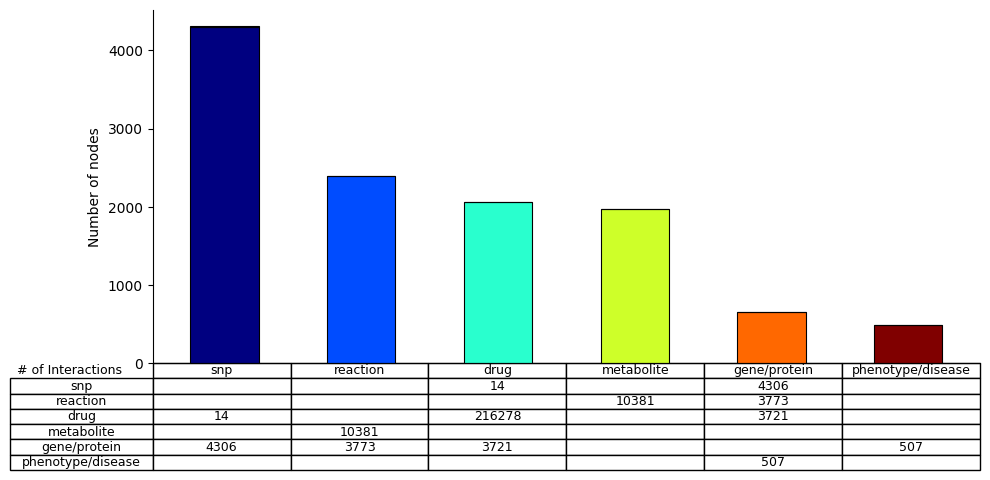

In [21]:
cmap = mpl.colormaps["jet"].resampled(len(df_node_summary.index))
node_colors_dict = {
    node_type: mpl.colors.to_hex(cmap(idx))
    for idx, node_type in enumerate(df_node_summary.index)
}

cmap = mpl.colormaps["viridis"].resampled(len(df_edge_summary.index))
edge_colors_dict = {
    node_type: mpl.colors.to_hex(cmap(idx))
    for idx, node_type in enumerate(df_edge_summary.index)
}
# node_colors_dict = {
#     "drug": mpl.colors.to_hex("xkcd:red"),
#     "snp":  mpl.colors.to_hex("xkcd:blue"),
#     "gene/protein":  mpl.colors.to_hex("xkcd:yellow"),
#     "phenotype/disease":  mpl.colors.to_hex("xkcd:pink"),
#     "reaction": mpl.colors.to_hex("xkcd:green"),
#     "metabolite": mpl.colors.to_hex("xkcd:purple"),
# }
# edge_colors_dict = {
#      "drug-drug": mpl.colors.to_hex("xkcd:red"),
#      "drug-gene/protein": mpl.colors.to_hex("xkcd:purple"),
#      "drug-snp": mpl.colors.to_hex("xkcd:orange"),
#      "gene/protein-snp": mpl.colors.to_hex("xkcd:green"),
#      "gene/protein-phenotype/disease": mpl.colors.to_hex("xkcd:magenta"),
#      "gene/protein-reaction": mpl.colors.to_hex("xkcd:light blue"),
#      "reaction-metabolite": mpl.colors.to_hex("xkcd:light blue"),
# }
include_isolated = True
fig, ax_nodes = plt.subplots(1, 1, figsize=(10, 5))
sns.despine(fig)
barsize = 0.5
edgecolor = "black"
edgewidth = 0.8


df_nodes = (
    pd.concat((df_node_summary, df_isolated_summary), axis=1).fillna(0).astype(int)
)
df_nodes.columns = ["Connected", "Isolated"]
table_cell_text = []

# include_isolated = False
offset = np.zeros(len(df_nodes.index))
for idx, (label, series) in enumerate(df_nodes.items()):
    if idx == 1:
        # Lighten the color for isolated nodes
        colors = [
            mpl.colors.to_hex(mpl.colors.to_rgba_array(node_colors_dict[k]) / 2 + 0.5)
            for k in series.index
        ]
    else:
        colors = [node_colors_dict[k] for k in series.index]
    rects = ax_nodes.bar(
        series.index,
        series.values,
        barsize,
        bottom=offset,
        color=colors,
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values
    if not include_isolated and idx == 0:
        break
ax_nodes.set_xticks([])
ax_nodes.set_xticklabels([])
ax_nodes.set_ylabel("Number of nodes")


for node_type_target in df_nodes.index:
    row_text = []
    for node_type_source in df_nodes.index:
        key = f"{node_type_source}-{node_type_target}"
        try:
            value = df_edge_summary[key]
        except KeyError:
            try:
                value = df_edge_summary[f"{node_type_target}-{node_type_source}"]
            except KeyError:
                value = ""
        row_text.append(str(value))
    table_cell_text.append(row_text)
table = ax_nodes.table(
    table_cell_text,
    rowLabels=df_nodes.index,
    colLabels=df_nodes.index,
    loc="bottom",
    cellLoc="center",
    rowLoc="center",
    colLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(9)
ax_nodes.annotate(
    "# of Interactions",
    xy=(-0.1, -0.03),
    xycoords=ax_nodes.transAxes,
    fontsize=9,
    ha="center",
)
fig.tight_layout()
fig;

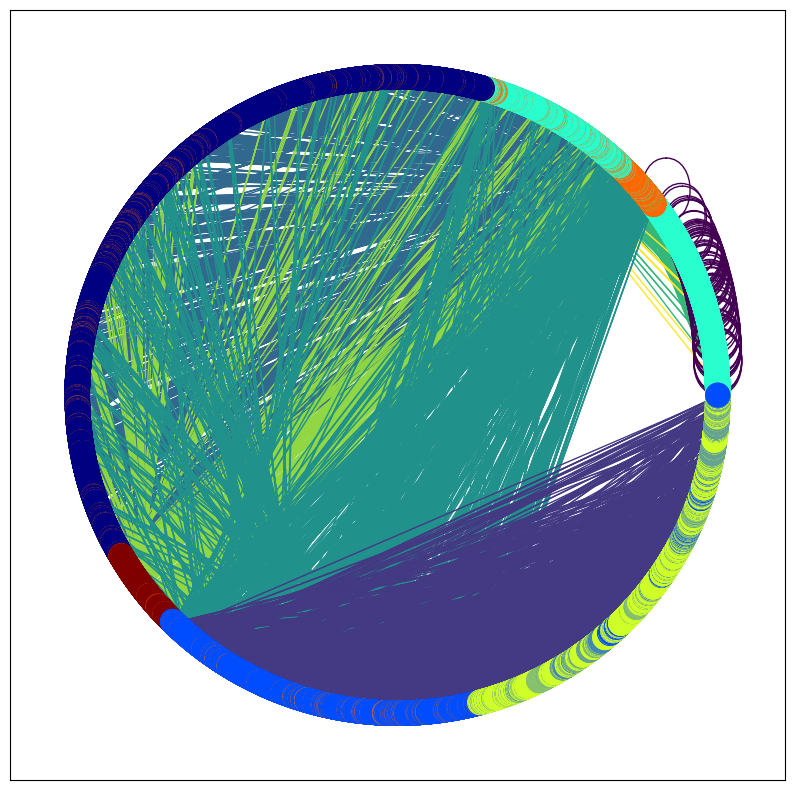

In [22]:
df_nodes = df_network_nodes.copy()
df_edges = df_network_edges.copy()

df_nodes["color"] = df_nodes["node_type"].apply(lambda x: node_colors_dict[x])
df_edges["color"] = df_edges["edge_type"].apply(lambda x: edge_colors_dict[x])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx_graph = nx.from_pandas_edgelist(
    df=df_edges,
    source="node_A",
    target="node_B",
    create_using=nx.Graph,
    edge_attr=True,
)
nx_graph.add_nodes_from(
    (n, dict(d))
    for n, d in df_nodes.set_index("node_id").iterrows()
    if n in nx_graph.nodes
)

node_colors = [attr_dict["color"] for (node_id, attr_dict) in nx_graph.nodes(data=True)]
edge_colors = [attr_dict["color"] for (x, y, attr_dict) in nx_graph.edges(data=True)]

pos = nx.circular_layout(nx_graph, scale=1, center=None, dim=2)
nx.draw_networkx_nodes(
    nx_graph,
    pos,
    ax=ax,
    # nodelist=None,
    # node_size=300,
    node_color=node_colors,
    # node_shape='o',
    # alpha=None,
    # cmap=None,
    # vmin=None,
    # vmax=None,
    # linewidths=None,
    # edgecolors=None,
    # label=None,
    # margins=None,
)
nx.draw_networkx_edges(
    nx_graph,
    pos,
    ax=ax,
    # edgelist=None,
    # width=1.0,
    edge_color=edge_colors,
    # style='solid',
    # alpha=None,
    # arrowstyle=None,
    # arrowsize=10,
    # edge_cmap=None,
    # edge_vmin=None,
    # edge_vmax=None,
    # arrows=None,
    # label=None,
    # node_size=300,
    # nodelist=None,
    # node_shape='o',
    # connectionstyle='arc3',
    # min_source_margin=0,
    # min_target_margin=0,
)
fig;